In [2]:
from dask.distributed import Client, LocalCluster
import time
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import MinMaxScaler
from dask_ml.wrappers import ParallelPostFit
import joblib


In [3]:
! ifconfig

em1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        ether 6c:2b:59:99:3f:d5  txqueuelen 1000  (Ethernet)
        RX packets 89639560  bytes 7182960037 (6.6 GiB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 579338  bytes 121660980 (116.0 MiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0
        device memory 0x92e00000-92efffff  

ib0: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 2044
        inet 192.168.101.112  netmask 255.255.0.0  broadcast 192.168.255.255
Infiniband hardware address can be incorrect! Please read BUGS section in ifconfig(8).
        infiniband 00:00:10:29:FE:80:00:00:00:00:00:00:00:00:00:00:00:00:00:00  txqueuelen 256  (InfiniBand)
        RX packets 17062016856  bytes 10509912814152 (9.5 TiB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 23289756819  bytes 25414468390660 (23.1 TiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0

lo: flags=73<UP,LOOPBACK,RUN

In [4]:
def initialize_cluster(n_workers, threads_per_worker, memory_limit, processes):
    """Initialize Dask LocalCluster with specified configurations."""
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=threads_per_worker,
        memory_limit=memory_limit,
        processes=processes,  # Set processes based on configuration
        host='192.168.101.112',
    )
    client = Client(cluster)
    print(f"Dask Dashboard Link: {client.dashboard_link}")
    cluster.scale(n_workers)
    return client, cluster

In [5]:
def data_loading_and_preprocessing(client, dataset_path, features, target):
    """Load and preprocess data using Dask."""
    df = dd.read_csv(dataset_path)
    X = df[features]
    Y = df[target]
    
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Feature engineering
    X_normalized['Temp_Wind'] = X_normalized['Temperature(F)'] * X_normalized['Wind_Speed(mph)']
    X_normalized['Visibility_Wind'] = X_normalized['Visibility(mi)'] * X_normalized['Wind_Speed(mph)']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, Y, test_size=0.2, random_state=42, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test


In [6]:
def model_training_and_evaluation(client, X_train, X_test, y_train, y_test):
    """Train and evaluate a Random Forest model using Dask."""
    start_time = time.time()
    
    with joblib.parallel_backend('dask'):
        model = ParallelPostFit(RandomForestClassifier(n_estimators=100, max_depth=5))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    end_time = time.time()
    
    accuracy = accuracy_score(y_test.compute(), y_pred.compute())
    
    return {"accuracy": accuracy, "time": end_time - start_time}

In [7]:
def visualize_performance(cluster_results):
    """Visualize execution time, speedup, and efficiency."""
    configs = list(cluster_results.keys())
    times = [cluster_results[config]['time'] for config in configs]
    speedups = [cluster_results[config]['speedup'] for config in configs]
    efficiencies = [cluster_results[config]['efficiency'] for config in configs]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    # Execution Time Graph
    ax1.plot(configs, times, marker='o', color='orange', linewidth=2)
    ax1.set_ylabel('Time (seconds)', color='orange')
    ax1.set_title('Execution Time')
    ax1.grid(True)

    # Speedup Graph
    ax2.plot(configs, speedups, marker='s', color='blue', linewidth=2)
    ax2.set_ylabel('Speedup', color='blue')
    ax2.set_title('Speedup')
    ax2.grid(True)

    # Efficiency Graph
    ax3.plot(configs, efficiencies, marker='^', color='green', linewidth=2)
    ax3.set_ylabel('Efficiency', color='green')
    ax3.set_title('Efficiency')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
def main():
    dataset_path = "Cleaned_US_Accidents_March23.csv"
    features = ['Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)']
    target = 'Severity'

    # Cluster configurations: baseline uses processes=False; others use processes=True
    cluster_configs = {
        "baseline_1_worker_1_thread": {"n_workers": 1, "threads_per_worker": 1, "memory_limit": "8GB", "processes": True},
        "2": {"n_workers": 2, "threads_per_worker": 1, "memory_limit": "8GB", "processes": True},
        "4": {"n_workers": 4, "threads_per_worker": 1, "memory_limit": "8GB", "processes": True},
        "6": {"n_workers": 6, "threads_per_worker": 1, "memory_limit": "8GB", "processes": True},
        "8": {"n_workers": 8, "threads_per_worker": 1, "memory_limit": "8GB", "processes": True},
        "10": {"n_workers": 10, "threads_per_worker": 1, "memory_limit": "8GB", "processes": True},
    }

    baseline_time = None
    cluster_results = {}

    for config_name, config_params in cluster_configs.items():
        print(f"Testing {config_name}...")
    
        client, cluster = initialize_cluster(**config_params)

        try:
            X_train, X_test, y_train, y_test = data_loading_and_preprocessing(
                client,
                dataset_path,
                features,
                target
            )
            result = model_training_and_evaluation(client, X_train, X_test, y_train, y_test)

            # Handle baseline configuration
            if config_name == "baseline_1_worker_1_thread":
                baseline_time = result["time"]
                if baseline_time is None or baseline_time <= 0:
                    raise ValueError("Baseline time is not set or invalid. Ensure the baseline configuration runs correctly.")
                speedup = 1
                efficiency = 1
            else:
                # Ensure baseline time is initialized before calculating speedup and efficiency
                if baseline_time is None:
                    raise ValueError("Baseline time has not been initialized. Run the baseline configuration first.")
                speedup = baseline_time / result["time"]
                efficiency = speedup / config_params["n_workers"]

            cluster_results[config_name] = {
                "accuracy": result["accuracy"],
                "time": result["time"],
                "speedup": speedup,
                "efficiency": efficiency,
            }
            
        finally:
            client.close()
            cluster.close()      

    visualize_performance(cluster_results)

Testing baseline_1_worker_1_thread...
Dask Dashboard Link: http://192.168.101.112:8787/status
Testing 2...
Dask Dashboard Link: http://192.168.101.112:8787/status
Testing 4...
Dask Dashboard Link: http://192.168.101.112:8787/status
Testing 6...
Dask Dashboard Link: http://192.168.101.112:8787/status
Testing 8...
Dask Dashboard Link: http://192.168.101.112:8787/status
Testing 10...
Dask Dashboard Link: http://192.168.101.112:8787/status


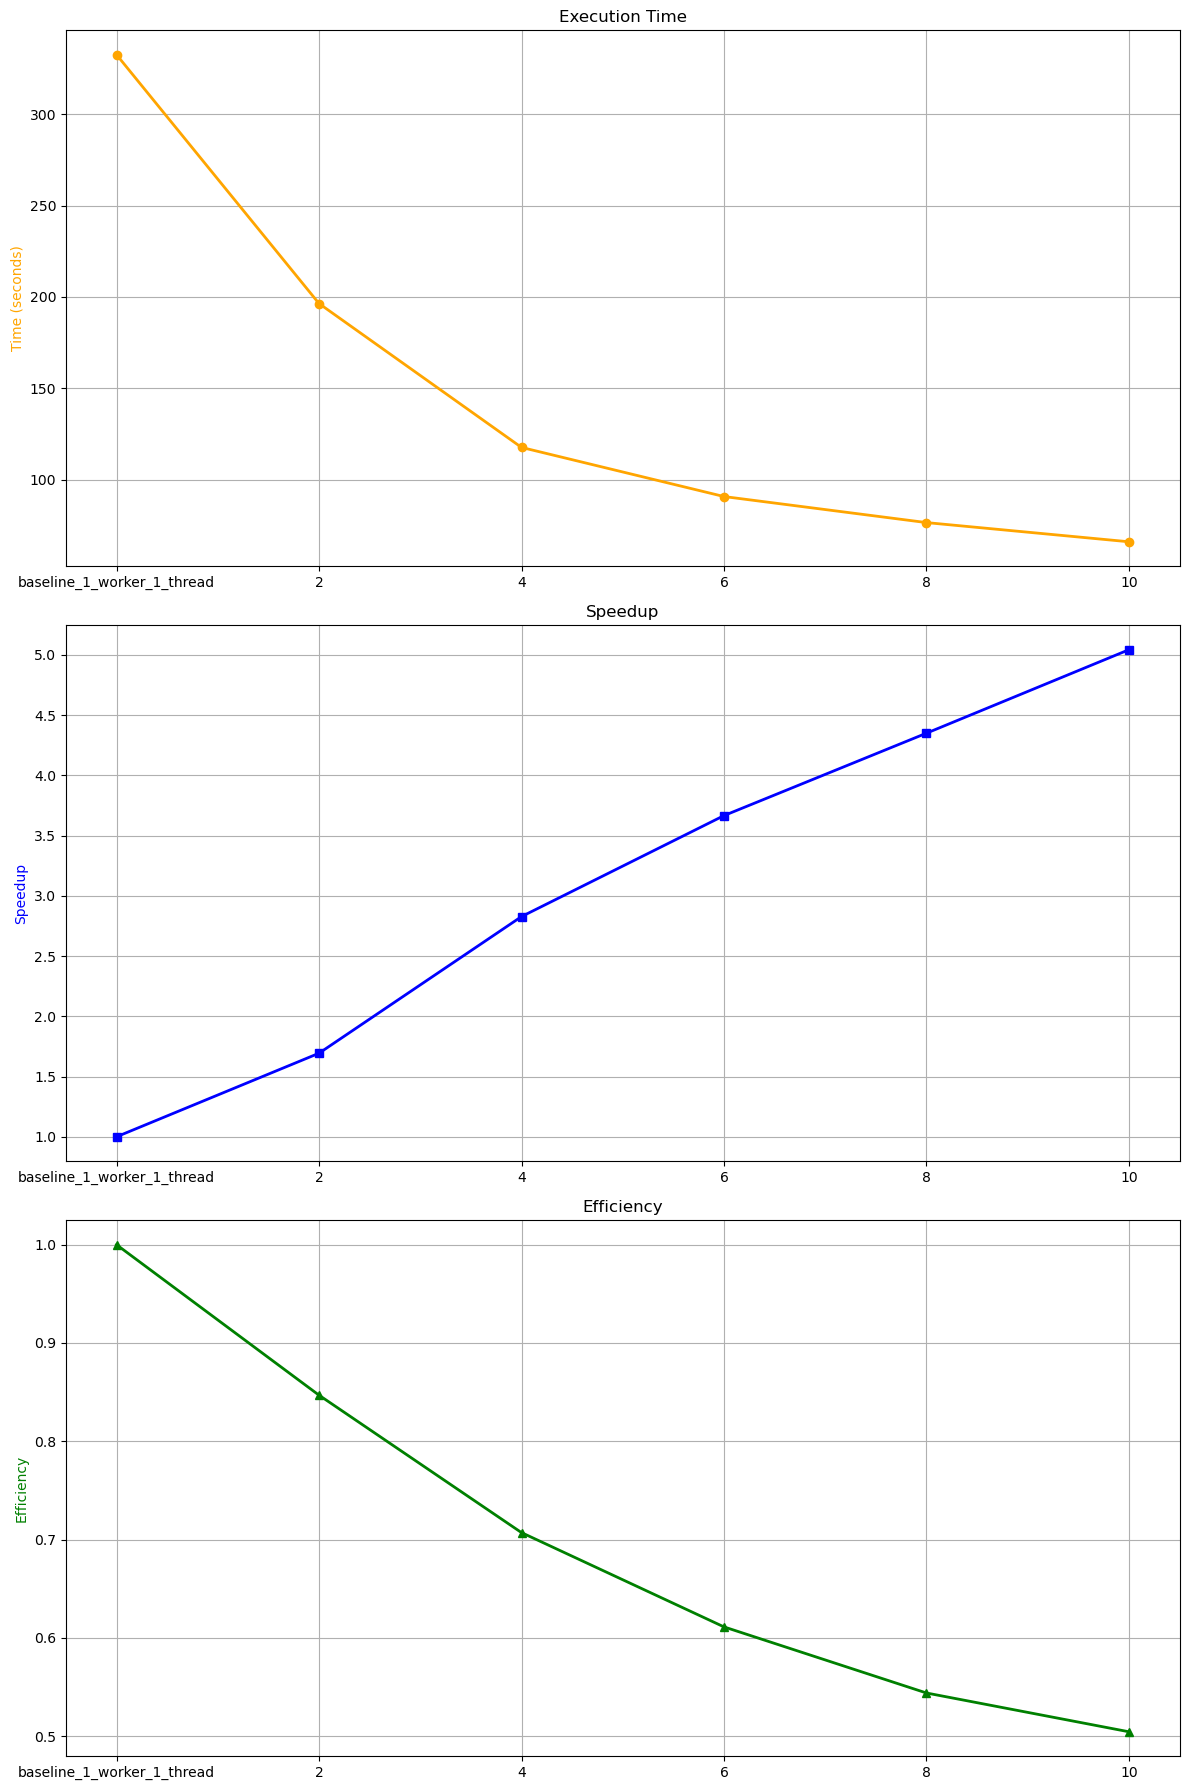

In [14]:
if __name__ == "__main__":
    main()